# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
training_file = "../traffic-signs-data/train.p"
testing_file = "../traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [2]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = len(train['features'])

# TODO: number of testing examples
n_test = len(test['features'])

# TODO: what's the shape of an image?
sample_image_shape = train['sizes'][0]

# TODO: how many classes are in the dataset
n_classes = len(set(train['labels']))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", sample_image_shape)
print("Number of classes =", n_classes)

print("Length features,labels,sizes  =", len(train['features']),"," ,len(train['labels']),",", len(train['sizes']))

#print("1st feature =", train['features'][0])
#print("1st size =", train['sizes'][0])
#print("1st label =", train['labels'][0])
#print("1st coords =", train['coords'][0])


Number of training examples = 39209
Number of testing examples = 12630
Image data shape = [29 30]
Number of classes = 43
Length features,labels,sizes  = 39209 , 39209 , 39209


In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
import numpy as np
import scipy as scipy
import math
import cv2
import argparse
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

In [5]:
tf.__version__

'0.12.1'

In [6]:
# Problem 1 - Implement Min-Max scaling for greyscale image data
def normalize_greyscale(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    a = 0.1
    b = 0.9
    greyscale_min = 0
    greyscale_max = 255
    return a + ( ( (image_data - greyscale_min)*(b - a) )/( greyscale_max - greyscale_min ) )

In [7]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [8]:
def transform_image(img, ang_range, shear_range, trans_range):
    """
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over. 
    
    A Random uniform distribution is used to generate different parameters for transformation
    
    Copied from confluence post
    https://carnd-udacity.atlassian.net/wiki/display/CAR/Project+2+%28unbalanced+data%29+Generating+additional+data+by+jittering+the+original+image
    """
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
    
    return img

In [9]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
#enc = preprocessing.OneHotEncoder()
lb.fit(train['labels'])
print(train['labels'][10000])
train['hot-labels'] = lb.transform(train['labels'])
test['hot-labels'] = lb.transform(test['labels'])
print(train['hot-labels'][10000])

train["input-features"] = []
test["input-features"] = []
train["input-features-noresize"] = []
test["input-features-noresize"] = []

image_size_tuple = (32,32,3)
image_size_flat = 32*32*3

for i, option in enumerate(train['features']):
    #print('Size - ', train['sizes'][i])
    #print('Size - ', len(train['features'][i]))
    tempTrainFeature = scipy.misc.imresize(train['features'][i], image_size_tuple , interp='bilinear')
    
    trainVertices = np.array([[(train['coords'][i][0],train['coords'][i][1]),
                               (train['coords'][i][0],train['coords'][i][3]), 
                               (train['coords'][i][2],train['coords'][i][3]), 
                               (train['coords'][i][2],train['coords'][i][1])]],
                            dtype=np.int32)
    
    #### Trim For Region of interest
    #tempTrainFeature=region_of_interest(tempTrainFeature, trainVertices)
    #tempTrainFeature=tempTrainFeature.reshape(image_size_tuple)
    
    #### Convert to Grey Scale
    #tempTrainFeature=normalize_greyscale(tempTrainFeature)
    
    #feature = np.array(tempTrainFeature, dtype=np.float32).flatten()
    #print(len(feature))
    
    ##Transform image to generate new image.
    tempTrainFeature = transform_image(tempTrainFeature, 20, 10, 5)
    
    tempTrainFeatureResize = tempTrainFeature.reshape(image_size_flat)
    
    train["input-features"].append(tempTrainFeatureResize)     
    train["input-features-noresize"].append(tempTrainFeature)   
    #print('done - ', i)
for j, option in enumerate(test['features']):
    #print('Size - ', test['sizes'][j])
    tempTestFeature = scipy.misc.imresize(test['features'][j], image_size_tuple, interp='bilinear')
    
    testVertices = np.array([[(test['coords'][j][0],test['coords'][j][1]),
                               (test['coords'][j][0],test['coords'][j][3]), 
                               (test['coords'][j][2],test['coords'][j][3]), 
                               (test['coords'][j][2],test['coords'][j][1])]],
                            dtype=np.int32)
    #tempTestFeature=region_of_interest(tempTestFeature, testVertices)
    #tempTestFeature=tempTestFeature.reshape(image_size_tuple)
    
    #testfeature = np.array(tempTestFeature, dtype=np.float32).flatten()
    #tempTestFeature=normalize_greyscale(tempTestFeature)
    tempTestFeatureResize = tempTestFeature.reshape(image_size_flat)
    
    test["input-features"].append(tempTestFeatureResize)
    test["input-features-noresize"].append(tempTestFeature)  
    #print('done - ', j)

print("Train Feature Count = ", len(train["input-features-noresize"]))
print("Test Feature Count = ", len(test["input-features-noresize"]))
print('Pre processing done.')

6
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]
Train Feature Count =  39209
Test Feature Count =  12630
Pre processing done.


In [10]:
def plot_images(images, labels, cls_pred=None, rect_coords=None, reshape=True):
    assert len(images) == len(labels) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        # Plot image.
        #newImgArr = scipy.misc.imresize(images[i], (30,30), interp='bilinear')
        if reshape==False:
            ax.imshow(images[i], cmap='binary') #.reshape(img_shape)
        else:
            ax.imshow(images[i].reshape(image_size_tuple), cmap='binary')
            
        # Create a Rectangle for the co-ordinates
        if rect_coords is not None:
            rect = patches.Rectangle((rect_coords[i][0],rect_coords[i][1]),(rect_coords[i][2]-rect_coords[i][0]),(rect_coords[i][3]-rect_coords[i][1]),linewidth=1,edgecolor='r',facecolor='none')
            ax.add_patch(rect)
        
        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(labels[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(labels[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

Original Images -
New Reshaped Images -


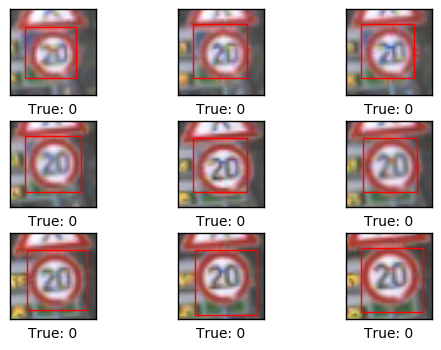

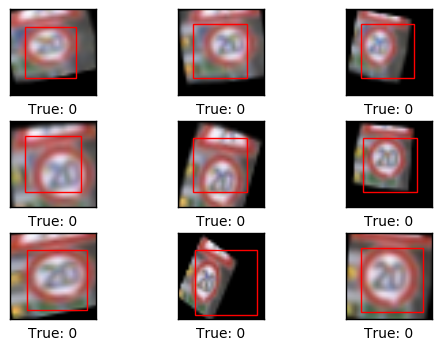

In [11]:
# Get the images from the test-set.
#[38000:38009]
images = train['input-features-noresize'][0:9]

# Get the true labels for those images.
labels = train['labels'][0:9]

# Get the sizes for those images.
sizes = train['sizes'][0:9]
coords = train['coords'][0:9]
# Plot the images and labels using our helper-function above.
print("Original Images -")
plot_images(images=train['features'][0:9], labels=labels, cls_pred=None, rect_coords=coords, reshape=False)

print("New Reshaped Images -")
plot_images(images=images, labels=labels, cls_pred=None, rect_coords=coords, reshape=False)

Original Test Images -
New Reshaped Test Images -


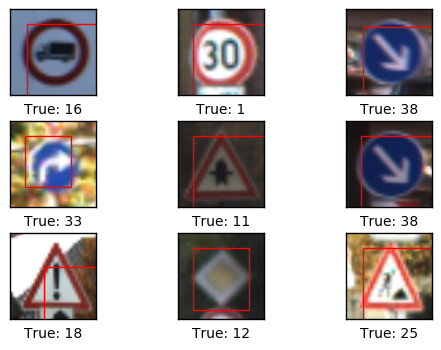

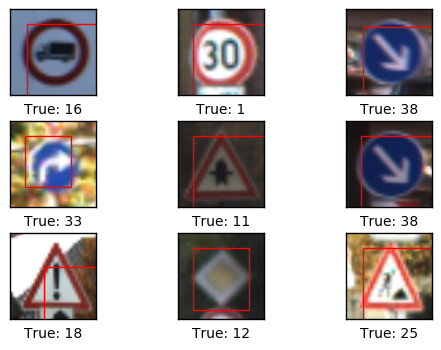

In [12]:
# Plot the TEST images and labels using our helper-function above.
print("Original Test Images -")
plot_images(images=test['features'][0:9], labels=test['labels'][0:9], cls_pred=None, rect_coords=test['coords'][0:9], reshape=False)

print("New Reshaped Test Images -")
plot_images(images=test['input-features-noresize'][0:9], labels=test['labels'][0:9], cls_pred=None, rect_coords=test['coords'][0:9], reshape=False)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [13]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

In [14]:
#img_size_flat = img_size * img_size
img_size_flat = 32 * 32 *3
num_classes = n_classes 
print(num_classes)

43


In [15]:
## COVNET NN GRAPH #####

# Parameters
learning_rate = 0.1
batch_size = 100
training_epochs = 30

layer_width = {
    'layer_1': 32,
    'layer_2': 64,
    'layer_3': 128,
    'fully_connected': 512
}

"""  
weights = {
    'layer_1': tf.Variable(tf.truncated_normal(
        [5, 5, 3, layer_width['layer_1']])),
    'layer_2': tf.Variable(tf.truncated_normal(
        [5, 5, layer_width['layer_1'], layer_width['layer_2']])),
    'layer_3': tf.Variable(tf.truncated_normal(
        [5, 5, layer_width['layer_2'], layer_width['layer_3']])),
    'fully_connected': tf.Variable(tf.truncated_normal(
        [1024, layer_width['fully_connected']])),
    'out': tf.Variable(tf.truncated_normal(
        [layer_width['fully_connected'], n_classes]))
}

biases = {
    'layer_1': tf.Variable(tf.zeros(layer_width['layer_1'])),
    'layer_2': tf.Variable(tf.zeros(layer_width['layer_2'])),
    'layer_3': tf.Variable(tf.zeros(layer_width['layer_3'])),
    'fully_connected': tf.Variable(tf.zeros(layer_width['fully_connected'])),
    'out': tf.Variable(tf.zeros(n_classes))
}
"""

"""
weights = {
    'layer_1': tf.Variable(tf.truncated_normal(
        [5, 5, 3, layer_width['layer_1']])),
    'fully_connected': tf.Variable(tf.truncated_normal(
        [8192, layer_width['fully_connected']])),
    'out': tf.Variable(tf.truncated_normal(
        [layer_width['fully_connected'], n_classes]))
}

biases = {
    'layer_1': tf.Variable(tf.zeros(layer_width['layer_1'])),
    'fully_connected': tf.Variable(tf.zeros(layer_width['fully_connected'])),
    'out': tf.Variable(tf.zeros(n_classes))
}

weights = {
    'wc1': tf.Variable(tf.random_normal([5, 5, 3, 6])),
    'wc2': tf.Variable(tf.random_normal([5, 5, 6, 16])),
    'fc1': tf.Variable(tf.random_normal([5*5*16, 120])),
    'fc2': tf.Variable(tf.random_normal([120, 84])),
    'out': tf.Variable(tf.random_normal([84, n_classes]))}

biases = {
    'bc1': tf.Variable(tf.random_normal([6])),
    'bc2': tf.Variable(tf.random_normal([16])),
    'fbc1': tf.Variable(tf.random_normal([120])),
    'fbc2': tf.Variable(tf.random_normal([84])),
    'out': tf.Variable(tf.random_normal([n_classes]))}
"""

mu = 0
sigma = 0.1
weights = {
    'wc1': tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma)),
    'wc2': tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma)),
    'fc1': tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma)),
    'fc2': tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma)),
    'out': tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))}

biases = {
    'bc1': tf.Variable(tf.zeros([6])),
    'bc2': tf.Variable(tf.zeros([16])),
    'fbc1': tf.Variable(tf.zeros([120])),
    'fbc2': tf.Variable(tf.zeros([84])),
    'out': tf.Variable(tf.zeros([n_classes]))}

#tf.summary.image('layer_1_weights', tf.expand_dims([weights['layer_1']], -1))
#tf.summary.image('layer_1_weights', weights['layer_1'])

def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='SAME')

#Create model
def conv_net(x, weights, biases):
    # Layer 1
    conv1 = conv2d(x, weights['layer_1'], biases['layer_1'])
    conv1 = maxpool2d(conv1, k=2)
    print("conv1=============", conv1.get_shape())
    
    # Layer 2
    conv2 = conv2d(conv1, weights['layer_2'], biases['layer_2'])
    conv2 = maxpool2d(conv2, k=2)
    print("conv2=============", conv2.get_shape())
    
    # Layer 3
    conv3 = conv2d(conv2, weights['layer_3'], biases['layer_3'])
    conv3 = maxpool2d(conv2, k=2)
    print("conv3=============", conv3.get_shape())
    
    # Fully connected layer
    ## Reshape conv3 output to fit fully connected layer input
    fc1 = tf.reshape(
        conv2,
        [-1, weights['fully_connected'].get_shape().as_list()[0]])
    
    ### Flattening instead of reshape
    fc1 = tf.contrib.layers.flatten(conv3) ###conv1
    print("fc1==FLAT===========", fc1.get_shape())
    
    fc1 = tf.add(
        tf.matmul(fc1, weights['fully_connected']),
        biases['fully_connected'])
    fc1 = tf.nn.relu(fc1)
    print("fc1=============", fc1.get_shape())
    
    # Output Layer - class prediction
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

def LeNet(x, weights, biases):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer

    
    # TODO: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1 = tf.nn.conv2d(x, weights['wc1'], strides=[1, 1, 1, 1], padding='VALID')
    conv1 = tf.nn.bias_add(conv1, biases['bc1'])
    print("conv1=============", conv1.get_shape())
    
    # TODO: Activation.
    conv1 = tf.nn.relu(conv1)
    
    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    print("conv1-pooling============", conv1.get_shape())
    
    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    conv2 = tf.nn.conv2d(conv1, weights['wc2'], strides=[1, 1, 1, 1], padding='VALID')
    conv2 = tf.nn.bias_add(conv2, biases['bc2'])
    print("conv2=============", conv2.get_shape())
    
    # TODO: Activation.
    conv2 = tf.nn.relu(conv2)
    
    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    print("conv2-pooling=============", conv2.get_shape())
    
    # TODO: Flatten. Input = 5x5x16. Output = 400.
    fc1 = tf.contrib.layers.flatten(conv2)
    print("conv2-flatten=============", fc1.get_shape())
    
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1 = tf.add(tf.matmul(fc1, weights['fc1']), biases['fbc1'])
    print("fc1=============", fc1.get_shape())
    
    # TODO: Activation.
    fc1 = tf.nn.relu(fc1)
    
    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2 = tf.add(tf.matmul(fc1, weights['fc2']), biases['fbc2'])
    print("fc2=============", fc2.get_shape())
    
    # TODO: Activation.
    fc2 = tf.nn.relu(fc2)
    
    # TODO: Layer 5: Fully Connected. Input = 84. Output = 10.
    logits = tf.add(tf.matmul(fc2, weights['out']), biases['out'])
    print("output-logits=============", logits.get_shape())

    return logits

# tf Graph input
x = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.float32, [None, num_classes])
y_true = tf.placeholder(tf.float32, [None, num_classes])
y_true_cls = tf.placeholder(tf.int64, [None])

#logits = conv_net(x, weights, biases)
logits = LeNet(x, weights, biases)

y_pred = tf.nn.softmax(logits)
y_pred_cls = tf.argmax(y_pred, dimension=1)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, y))
#optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
#optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)

#correct_prediction = tf.equal(y_pred_cls, y_true_cls)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

#grads_and_vars = optimizer.compute_gradients(cost)
#gradients = list(zip(grads_and_vars))[0]
#tf.summary.histogram('gradients', gradients)

#train_op = optimizer.apply_gradients(grads_and_vars)
#optimizer = optimizer.minimize(cost)

tf.summary.scalar('cost', cost)
tf.summary.scalar('accuracy', accuracy)
summary_op = tf.summary.merge_all()


conv1============= (?, 28, 28, 6)
conv1-pooling============ (?, 14, 14, 6)
conv2============= (?, 10, 10, 16)
conv2-pooling============= (?, 5, 5, 16)
conv2-flatten============= (?, 400)
fc1============= (?, 120)
fc2============= (?, 84)
output-logits============= (?, 43)


In [16]:
########################################
############ LINEAR NN GRAPH ###########
########################################
#x = tf.placeholder(tf.float32, [None, img_size_flat])
#y_true = tf.placeholder(tf.float32, [None, num_classes])
#y_true_cls = tf.placeholder(tf.int64, [None])

#weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))
#biases = tf.Variable(tf.zeros([num_classes]))
#logits = tf.add(tf.matmul(x, weights),biases)
#weights2 = tf.Variable(tf.zeros([num_classes, num_classes]))
#biases2 = tf.Variable(tf.zeros([num_classes]))
#keep_prob = tf.placeholder(tf.float32)
###hidden_layer = tf.add(tf.matmul(x, weights),biases)
###hidden_layer = tf.nn.relu(hidden_layer)
###hidden_layer = tf.nn.dropout(hidden_layer, keep_prob)
###logits = tf.add(tf.matmul(hidden_layer, weights2), biases2)

#y_pred = tf.nn.softmax(logits)
#y_pred_cls = tf.argmax(y_pred, dimension=1)

#cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_true)
#cost = tf.reduce_mean(cross_entropy)

#optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(cost)

In [17]:
summaries_every = 10
output_dir = '/home/ubuntu/project2/traffic-signs/logs/covnet'
graph = tf.Graph()
session = tf.Session()
#session.run(tf.initialize_all_variables())
session.run(tf.global_variables_initializer())

writer = tf.summary.FileWriter(output_dir, graph=graph, flush_secs=1)
batch_count = int(math.ceil(len(train['input-features'])/batch_size))

# Measurements use for graphing loss and accuracy
log_batch_step = 100
batches = []
loss_batch = []
train_acc_batch = []
train_full_acc_batch = []
valid_acc_batch = []

feed_dict_train_full = {x: train["input-features-noresize"],
                        y: train["hot-labels"],
                        y_true: train["hot-labels"],
                        y_true_cls: train["labels"],
                        }

def optimize(num_iterations):
    for i in range(num_iterations):
        
        # Progress bar
        batches_pbar = tqdm(range(batch_count), desc='Iterations {:>2}/{}'.format(i+1, num_iterations), unit='batches')
        
        for batch_i in batches_pbar:
            # Get a batch of training examples.
            
            batch_start = batch_i*batch_size
            #print("batch_i=", batch_i, ",batch_start=", batch_start, "batch_size=", batch_size)
            #print("train Length", len(train["input-features-noresize"]), ", " , len(train["hot-labels"]), ", " , len(train["labels"]))
            batch_features = train["input-features-noresize"][batch_start:batch_start + batch_size]
            batch_labels = train["hot-labels"][batch_start:batch_start + batch_size]
            batch_labels_cls = train["labels"][batch_start:batch_start + batch_size]
            
            feed_dict_train = {x: batch_features,
                               y: batch_labels,
                               y_true: batch_labels,
                               y_true_cls: batch_labels_cls,
                               }
            
            #print("x=", len(feed_dict_train[x]))
            #print("y=", len(feed_dict_train[y]))
            #print("y_true=", len(feed_dict_train[y_true]))
            #print("y_true_cls=", len(feed_dict_train[y_true_cls]))

            # Run the optimizer using this batch of training data.
            # TensorFlow assigns the variables in feed_dict_train
            # to the placeholder variables and then runs the optimizer.
            #l = session.run([cost],feed_dict=feed_dict_train)
            #opt = session.run([optimizer],feed_dict=feed_dict_train)
            
            _, l, summaries  = session.run([optimizer, cost, summary_op],feed_dict=feed_dict_train)
            
            #print(batch_i % log_batch_step,", batches_pbar=",batches_pbar, ", batch_count=",batch_count, ",batch_start=", batch_start)
            
            # Log every 50 batches
            if not batch_i % log_batch_step:
                # Calculate Training and Validation accuracy
                training_accuracy_local = session.run(accuracy, feed_dict=feed_dict_train)
                training_accuracy_full = session.run(accuracy, feed_dict=feed_dict_train_full)
                validation_accuracy = session.run(accuracy, feed_dict=feed_dict_test)
                # Log batches
                #previous_batch = batches[-1] if batches else 0
                #batches.append(log_batch_step + previous_batch)
                print("batch_i=", str(batch_i) ,  "training_accuracy_local=", str(training_accuracy_local),
                      ",Loss=" , str(l), ",training_accuracy_full=", str(training_accuracy_full),
                      ",validation_accuracy=", str(validation_accuracy), "batches Length=", str(len(batches)))
                
                loss_batch.append(l)
                
                #train_acc_batch.append(training_accuracy_local)
                #train_full_acc_batch.append(training_accuracy_full)
                #valid_acc_batch.append(validation_accuracy)
        
        writer.add_summary(summaries, global_step=i)
        tf.logging.info('Wrote summaries at step {}'.format(i))
        print_weights(weights['out'])
        if not i % 10:
            # Check accuracy against Validation data
            validation_accuracy = session.run(accuracy, feed_dict=feed_dict_test)
            print("Optimized Validation Accuracy = ", str(validation_accuracy))

In [18]:
feed_dict_test = {x: test["input-features-noresize"],
                  y: test["hot-labels"],
                  y_true: test["hot-labels"],
                  y_true_cls: test["labels"],
                  }
print(len(feed_dict_test[x]))
print(len(feed_dict_test[y]))
print(len(feed_dict_test[y_true]))
print(len(feed_dict_test[y_true_cls]))

12630
12630
12630
12630


In [19]:
def plot_accuracy():
    loss_plot = plt.subplot(211)
    loss_plot.set_title('Loss')
    loss_plot.plot(batches, loss_batch, 'g')
    #loss_plot.set_xlim([0, len(batches)])
    acc_plot = plt.subplot(212)
    acc_plot.set_title('Accuracy')
    acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
    acc_plot.plot(batches, train_full_acc_batch, 'g', label='Training Accuracy Full')
    acc_plot.plot(batches, valid_acc_batch, 'b', label='Validation Accuracy')
    
    acc_plot.set_ylim([0, 1.0])
    #acc_plot.set_xlim([batches[0], batches[-1]])
    #acc_plot.set_xlim([0, len(batches)])
    acc_plot.legend(loc=2)
    plt.tight_layout()
    plt.show()

In [20]:
def print_accuracy():
    # Use TensorFlow to compute the accuracy.
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    
    # Print the accuracy.
    print("Accuracy on test-set: {0:.1%}".format(acc))

In [21]:
def print_weights(weightTensor):
    # Get the values for the weights from the TensorFlow variable.
    w = session.run(weightTensor)
    print("Total Weights = ", sum(w))
    #for i in range(num_classes):
    #    weights_x = w[:, i]
    #    print(i, "-->", sum(weights_x))

In [22]:
def print_confusion_matrix():
    # Get the true classifications for the test-set.
    cls_true = feed_dict_test[y_true_cls]
    
    # Get the predicted classifications for the test-set.
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

In [23]:
def plot_example_errors():
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)
    
    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = np.array(feed_dict_test[x])[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = feed_dict_test[y_true_cls][incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9], labels=cls_true[0:9], cls_pred=cls_pred[0:9])
    #plot_images(images=images[0:9], cls_true=cls_true[0:9], cls_pred=cls_pred[0:9])

In [24]:
def plot_example_success():
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = np.array(feed_dict_test[x])[correct]
    images_len = len(images)
    # Get the predicted classes for those images.
    cls_pred = cls_pred[correct]

    # Get the true classes for those images.
    cls_true = feed_dict_test[y_true_cls][correct]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9], labels=cls_true[0:9], cls_pred=cls_pred[0:9])
    plot_images(images=images[images_len-9:images_len], 
                labels=cls_true[images_len-9:images_len], 
                cls_pred=cls_pred[images_len-9:images_len])

In [25]:
def plot_weights(weightTensor):
    # Get the values for the weights from the TensorFlow variable.
    w = session.run(weightTensor)
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Create figure with 3x4 sub-plots,
    # where the last 2 sub-plots are unused.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.1)

    for i, ax in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.
        if i<num_classes:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, n_classes)
            image = w[:, i].reshape(32,16,1)

            # Set the label for the sub-plot.
            ax.set_xlabel("Weights: {0}".format(i))

            # Plot the image.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])

Accuracy on test-set: 1.2%


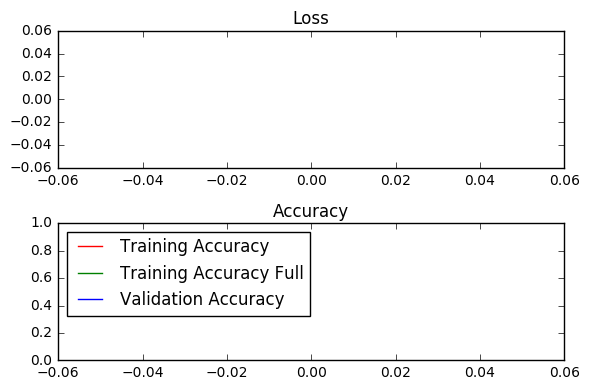

Plot Batches Length =  0


In [26]:
print_accuracy()
plot_accuracy()
print("Plot Batches Length = ", len(batches))

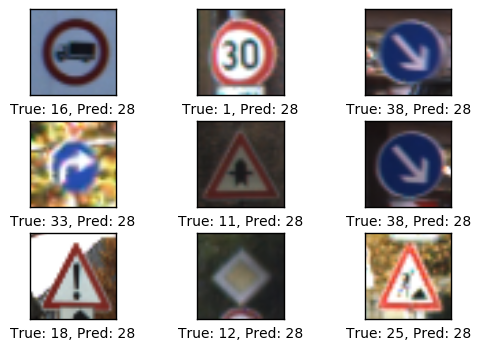

In [27]:
plot_example_errors()

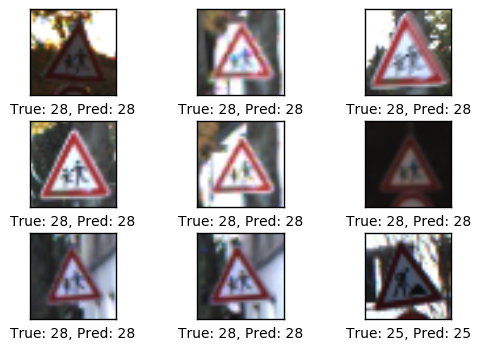

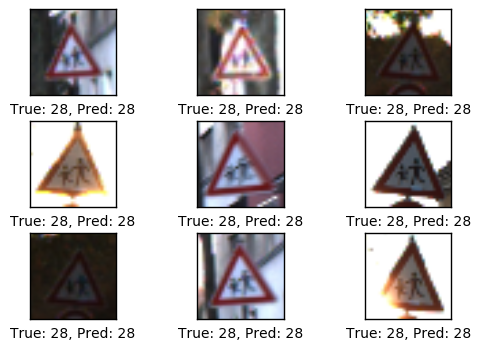

In [28]:
plot_example_success()

In [29]:
print_weights(weights['out'])

Total Weights =  [-0.1678378  -0.088434    0.05892467  1.18711913 -0.85566252  1.05625045
  0.12942487 -0.86091137  0.0794513   1.24961388  0.09825078  0.84112304
 -0.08799048 -0.75420415 -0.40081048  0.3839702   0.69466734  0.13115254
 -1.06802714  0.84052104  0.44494891  0.1379443   0.51307124  0.11319973
 -1.22336864  1.76495481  1.05052841  0.96090561  0.51477981 -1.16925502
 -0.48315793  0.3128292  -0.37667513 -0.14550392  0.13375804 -0.45502323
 -0.4730407  -0.34408313 -0.58272743 -0.08217723 -1.68711174  0.31950918
  0.62753069]


In [ ]:
#plot_weights(weights2)

In [ ]:
optimize(num_iterations=1000)

Iterations  1/1000:   1%|          | 4/393 [00:02<13:04,  2.02s/batches]

batch_i= 0 training_accuracy_local= 1.0 ,Loss= 95.3551 ,training_accuracy_full= 0.00535591 ,validation_accuracy= 0.00475059 batches Length= 0


Iterations  1/1000:  25%|██▌       | 99/393 [00:07<00:12, 23.13batches/s]

In [ ]:
print_accuracy()

In [ ]:
#print_accuracy()
plot_example_errors()
plot_example_success()
print_weights(weights['out'])

In [ ]:
#optimize(num_iterations=90)
#print_accuracy()
#plot_example_errors()
#plot_example_success()
#print_weights(weights['out'])

In [ ]:
#optimize(num_iterations=100)

In [ ]:
#print_accuracy()
#plot_example_errors()
#plot_example_success()
#print_weights(weights)

In [ ]:
#print_confusion_matrix()

In [ ]:
#session.close()

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

In [ ]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

In [ ]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [ ]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.